<h1>Time Series Analysis and Forecasting with LSTM</h1>
<h3>Objective</h3>
The goal of this notebook is to predict future values for each column in the dataset using Long Short-Term Memory (LSTM) models.

<strong>dataset</strong> - [Time Series starter dataset](https://www.kaggle.com/datasets/podsyp/time-series-starter-dataset/data)

this is my first time working with timeseries, so I appreciate any comments and suggestions



<h3>Outline</h3>
In this notebook, I will walk through the following steps:
<ul>
    <li style="margin-bottom: 5px"><strong>Data Exploration and Forecast Horizon</strong>: Initial examination of the dataset, determining the time period for predictions.</li>
    <li style="margin-bottom: 5px"><strong>Detrending</strong>: Removing long-term trends from the data.</li>
    <li style="margin-bottom: 5px"><strong>Deseasoning</strong>: Eliminating seasonal patterns to focus on the underlying data correlations.</li>
    <li style="margin-bottom: 5px"><strong>Post-Processing Analysis</strong>: Examining the data after detrending and deseasoning to ensure these processes were effective.</li>
    <li style="margin-bottom: 5px"><strong>Model Training and Evaluation</strong>: Training the LSTM model on the processed data and evaluating its performance.</li>
    <li style="margin-bottom: 5px"><strong>Predicting on Test Data</strong>: Making predictions on the test set to check the performance</li>
    <li style="margin-bottom: 5px"><strong>Model Training on Full Data</strong>: Retraining the model on the entire dataset to improve its forecasting ability.</li>
    <li style="margin-bottom: 5px"><strong>Final Prediction</strong>: Generating final predictions for future data points using the trained model.</li>
      <li style="margin-bottom: 5px"><strong>Completing Components For Forecasting</strong>: Adding each compontent for final result</li>
    <li style="margin-bottom: 5px"><strong>Conclusion</strong>: Summarizing the findings, discussing the results, and suggesting potential improvements.</li>
</ul>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

2024-08-12 11:15:49.114633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 11:15:49.114855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 11:15:49.300372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing data

dataset - [Time Series starter dataset](https://www.kaggle.com/datasets/podsyp/time-series-starter-dataset/data)



In [2]:
df = pd.read_csv("/kaggle/input/time-series-starter-dataset/Month_Value_1.csv")

# setting period as PeriodIndex with monthly freq
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df['Period'] = df.Period.dt.to_period('M')
df.set_index('Period', inplace=True)

df

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
2015-01,1.601007e+07,12729.0,1257.763541,30024676.0
2015-02,1.580759e+07,11636.0,1358.507000,30024676.0
2015-03,2.204715e+07,15922.0,1384.697024,30024676.0
2015-04,1.881458e+07,15227.0,1235.606705,30024676.0
2015-05,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...
2022-08,NaN,NaN,NaN,NaN
2022-09,NaN,NaN,NaN,NaN
2022-10,NaN,NaN,NaN,NaN


# Data Exploration and Forecast Horizon

<h4>goals:</h4>
<ul>
<li>check if there are any empty values, and decide what to do about them</li>
    <li>define forecast horizon</li>
    <li>find and inverstigate correlations</li>
</ul>

In [3]:
print(df.isna().sum())

# uncomment to see Nan rows
# df[-32:]

# Nan rows are at the end of the data meaning
# the data used for training purposes is non empty

Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64


<div class="alert alert-block alert-success">  
There are no missing values in training data   
</div>

<h3>Forecast horizon</h3>
The dataset concludes at index 63, corresponding to the date 01.04.2020, indicating the starting point for the predictions. The forecast horizon spans 33 periods, implying that data is available for only 65% of the rows in the dataframe.

In [4]:
test = df[-32:]
train = df[:len(df)-32]

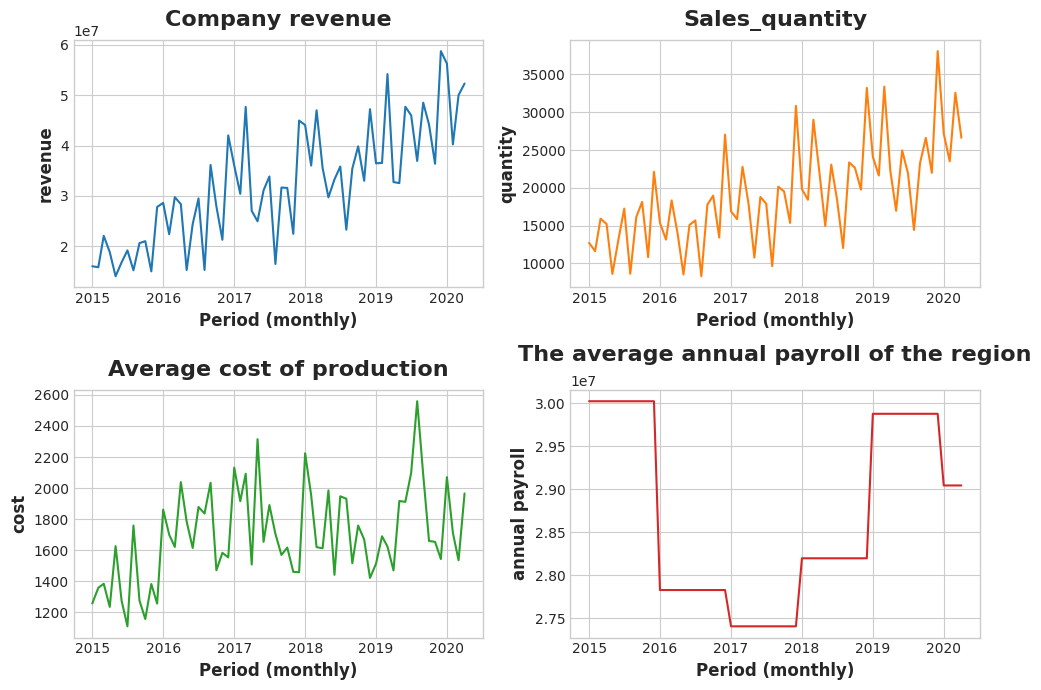

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs[0, 0].plot(train.index.to_timestamp(), train["Revenue"])
axs[0, 0].set_title("Company revenue")
axs[0, 0].set_xlabel("Period (monthly)")
axs[0, 0].set_ylabel("revenue")

axs[0, 1].plot(train.index.to_timestamp(), train["Sales_quantity"], 'tab:orange')
axs[0, 1].set_title("Sales_quantity")
axs[0, 1].set_xlabel("Period (monthly)")
axs[0, 1].set_ylabel("quantity")

axs[1, 0].plot(train.index.to_timestamp(), train["Average_cost"], 'tab:green')
axs[1, 0].set_title("Average cost of production")
axs[1, 0].set_xlabel("Period (monthly)")
axs[1, 0].set_ylabel("cost")

axs[1, 1].plot(train.index.to_timestamp(), train["The_average_annual_payroll_of_the_region"], 'tab:red')
axs[1, 1].set_title("The average annual payroll of the region")
axs[1, 1].set_xlabel("Period (monthly)")
axs[1, 1].set_ylabel("annual payroll")

plt.tight_layout()

plt.show()

<h3>Data Structure</h3>

There are four columns that represents
* ***Company Revenue***
* ***Sales Quantity***
* ***Average Cost of Production*** 
* ***Average Annual PPayroll of The Region***

<div class="alert alert-block alert-success">  
<strong>First look:</strong> Data looks clean, there's visible trend and seasonality.
</div>
 Let's check the correlations  

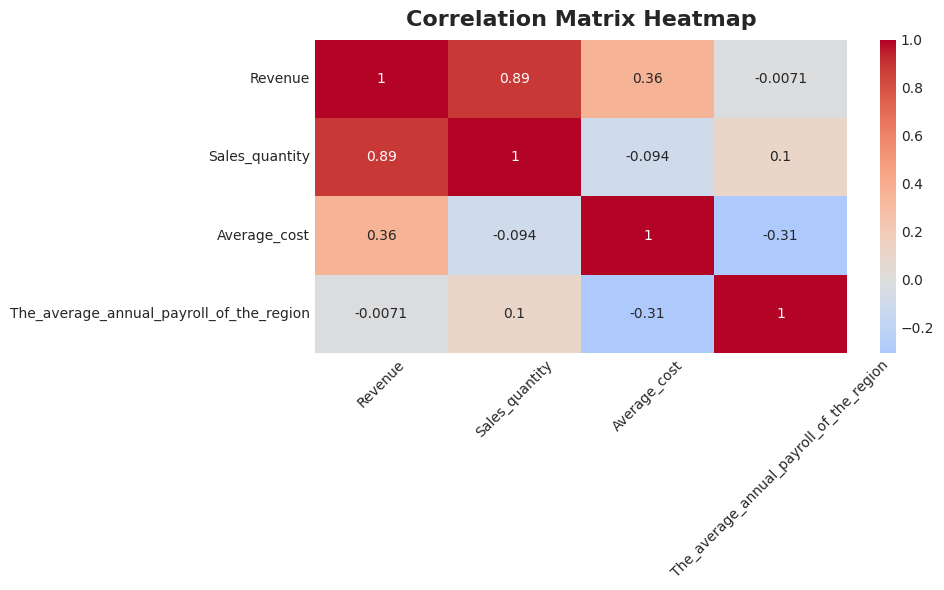

In [6]:
correlation_matrix = train.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">  
<strong>Correlations:</strong> Based on this corr matrix, there're visible correlations especially between <strong>Revenue</strong> and <strong>Sales_quantity</strong>. Overally the least correlated is annual payroll of the region.
</div>

# Detrending

<h4>goals:</h4>
<ul>
<li>examine trends</li>
   <li>store each trend and remove from main data</li>
</ul>

the reason for detrending data is to get access to more raw data in order to perform deeper correlations tests

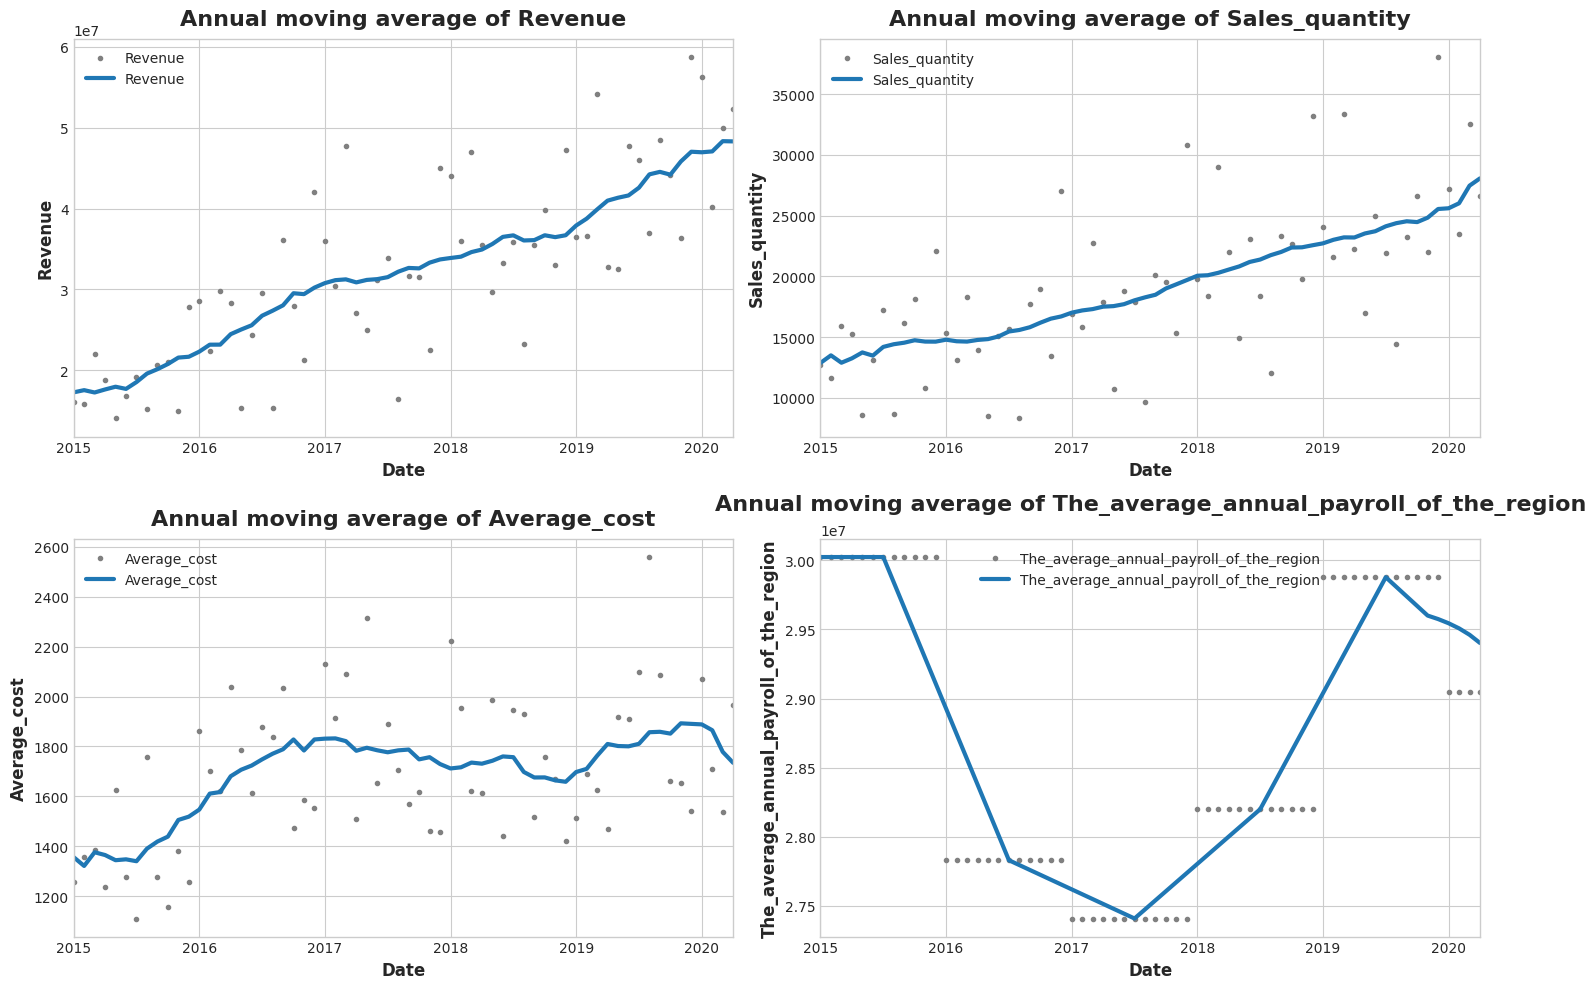

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

moving_averages = []

for i, column in enumerate(train.columns):
    moving_avg = train[column].rolling(window=12, center=True, min_periods=6).mean()
    
    moving_averages.append(moving_avg)
    
    ax = train[column].plot(ax=axes[i], style=".", color="0.5", title=column, legend=True)
    moving_avg.plot(ax=ax, linewidth=3, title=f"Annual moving average of {column}", legend=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

* Based on those **moving average** plots its visible that Revenue and Sales quantity have aproximately linear upwarding trends.
* Average cost is more complicated, there's probably some **polynomial** trend
* The most interesting is **the payroll**, the moving average plot suggests that there might have been an ongoing **crisis** in the past, making it difficult to discern any clear trend.

{'Revenue': '16304129.1691 + 494040.7105 * t', 'Sales_quantity': '11631.3393 + 232.8011 * t', 'Average_cost': '1127.7871 + 55.4575 * t + -1.5324 * t^2 + 0.0139 * t^3', 'The_average_annual_payroll_of_the_region': '28606874.5536 + 2583.2330 * t'}


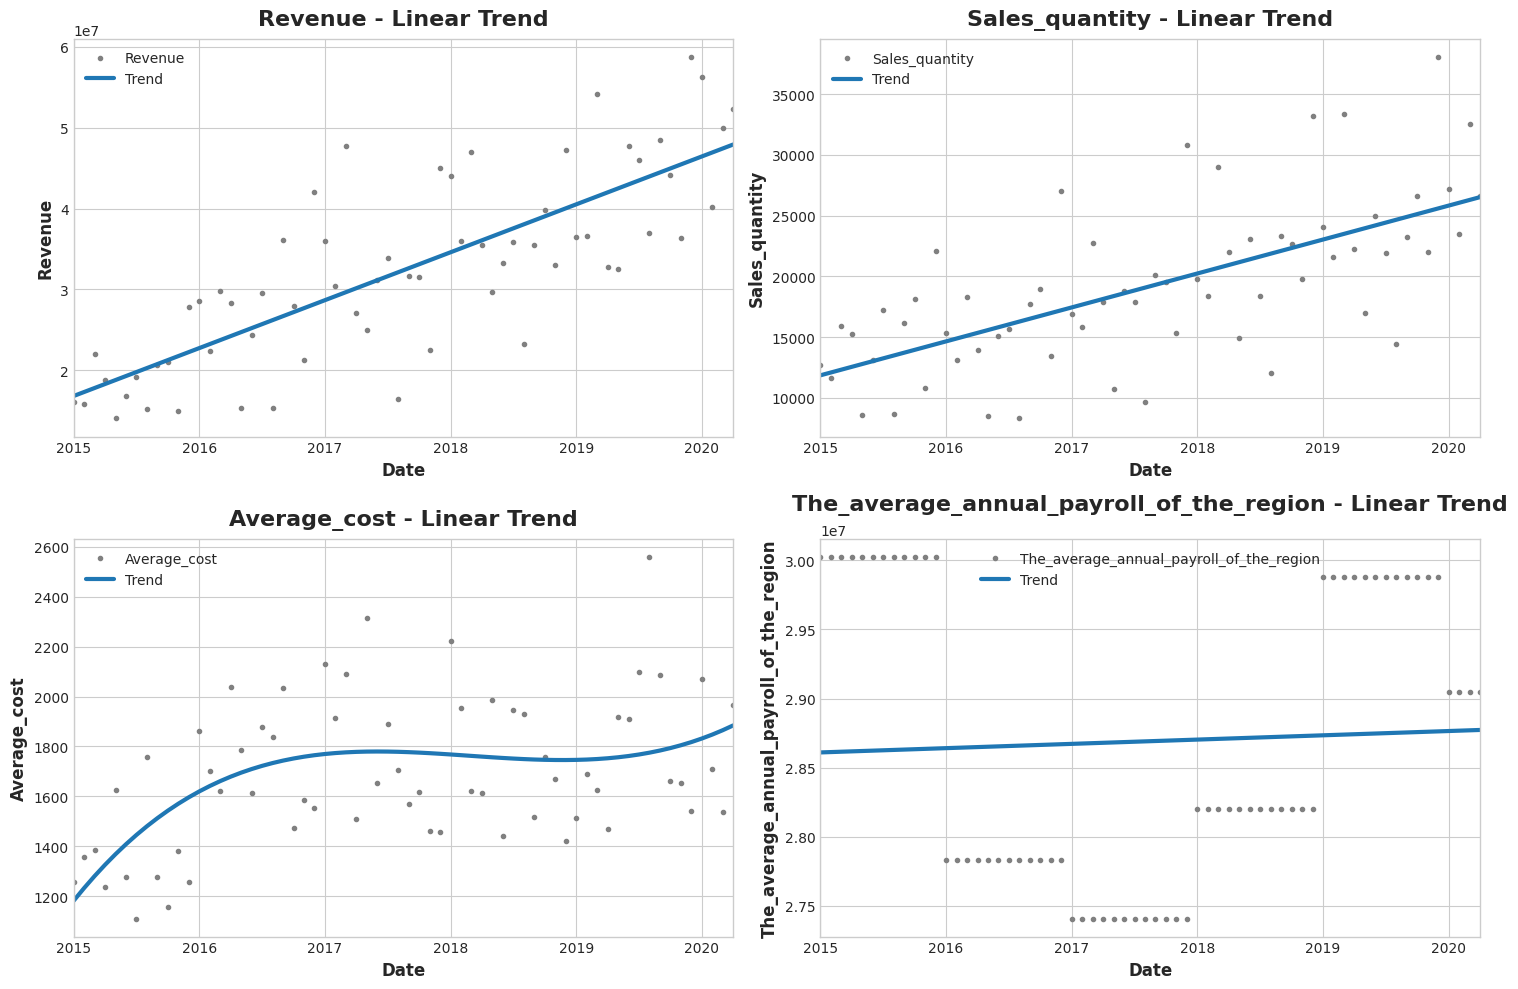

In [8]:
revenue = train[['Revenue']]
sales_quantity = train[['Sales_quantity']]
average_cost = train[['Average_cost']]
payroll = train[['The_average_annual_payroll_of_the_region']]

cols = [revenue, sales_quantity, average_cost, payroll]

# There are stored trends
trends = []
equations = {}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    dp = DeterministicProcess(
        index=col.index,
        constant=True,
        order=1,
        drop=True,
    )
    # Average_cost polynomial
    if i == 2:
        dp = DeterministicProcess(
        index=col.index,
        constant=True,
        order=4,
        drop=True,
    )
    X = dp.in_sample()
    y = col[col.columns[0]]
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    y_pred = pd.Series(model.predict(X), index=X.index)
    
    trends.append(model.predict(X))
    
    coefficients = model.coef_
    intercept = model.intercept_
    
    if i == 2:
        equations[col.columns[0]] = f"{coefficients[0]:.4f} + {coefficients[1]:.4f} * t + {coefficients[2]:.4f} * t^2 + {coefficients[3]:.4f} * t^3"
    else:
        equations[col.columns[0]] = f"{coefficients[0]:.4f} + {coefficients[1]:.4f} * t"
    
    ax = col.plot(ax=axes[i], style=".", color="0.5", title=f"{col.columns[0]} - Linear Trend")
    y_pred.plot(ax=ax, linewidth=3, label="Trend", legend=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(col.columns[0])

print(equations)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">  
<strong>Trends:</strong> Linear trends for first two columns work well also the polynomial plot with order = 3 fits average cost data correctly. 
</div>

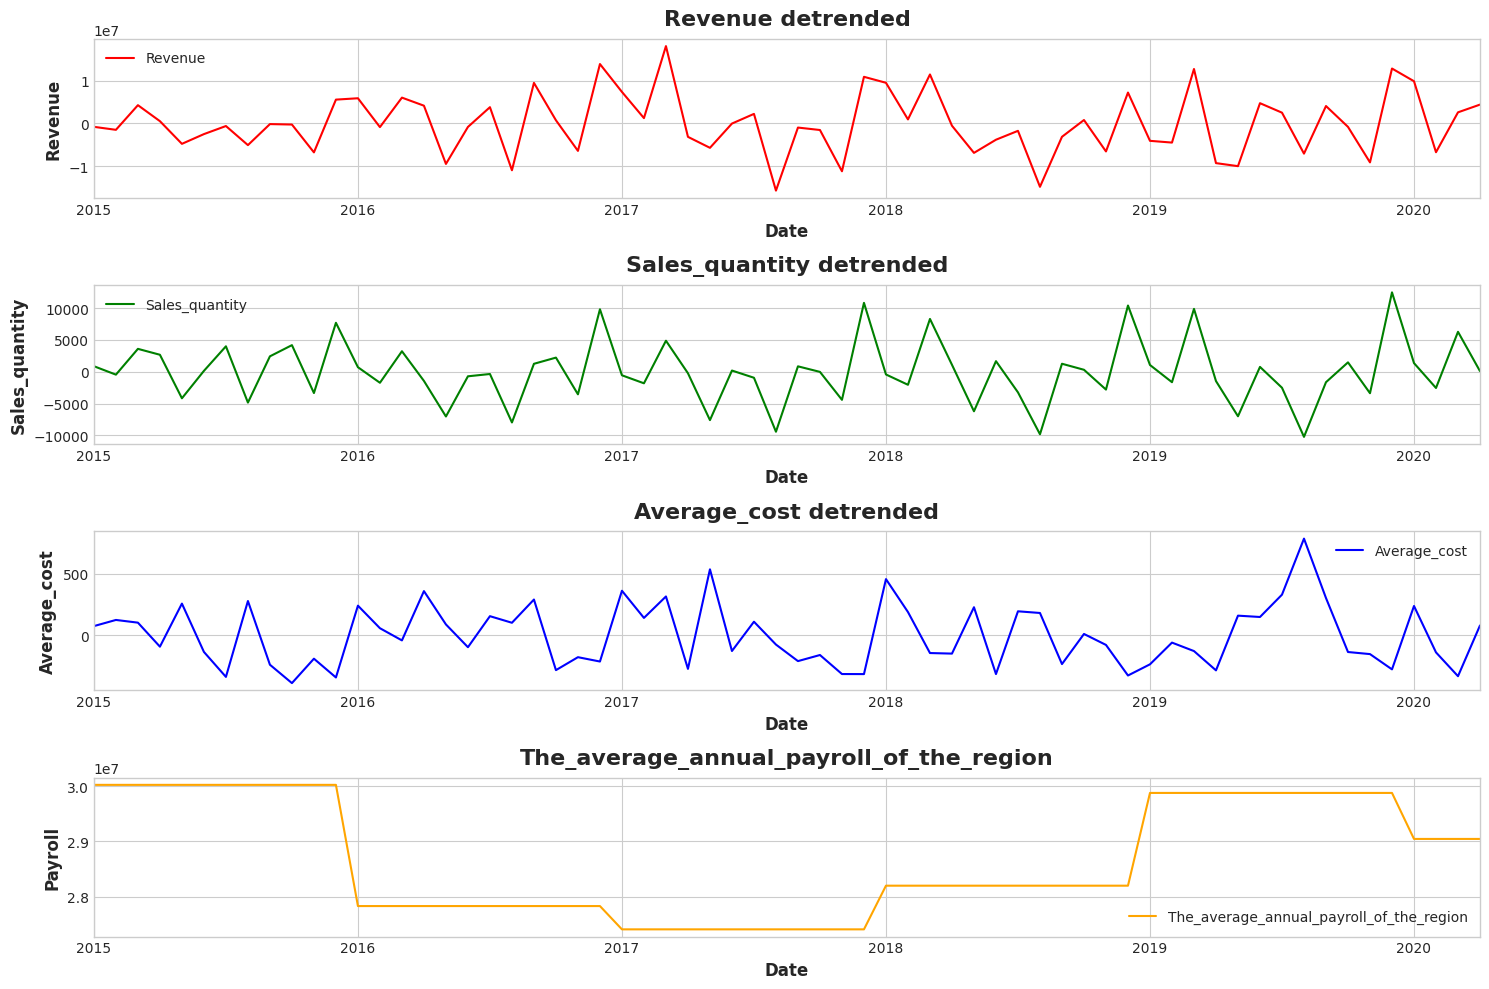

In [9]:
revenue_detrended = revenue["Revenue"] - trends[0]
sales_quantity_detrended = sales_quantity["Sales_quantity"] - trends[1]

average_cost_detrended = average_cost["Average_cost"] - trends[2]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
axes = axes.flatten()

ax = revenue_detrended.plot(ax=axes[0], color="red", title="Revenue detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Revenue")

ax = sales_quantity_detrended.plot(ax=axes[1], color="green", title="Sales_quantity detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Sales_quantity")

ax = average_cost_detrended.plot(ax=axes[2], color="blue", title="Average_cost detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Average_cost")

ax = payroll.plot(ax=axes[3], color="orange", title="The_average_annual_payroll_of_the_region", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Payroll")
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<strong>Detrended Data:</strong> 
This is what the data looks like after removing trends. Although the trend has been eliminated, the seasonality is still visible, so let's proceed with addressing that next.
</div>


<div class="alert alert-block alert-danger">  
<strong>Payroll:</strong>
    At this point I decided to postpone until later working with payroll. This is because it's the most complicated part of dataset and has the least correlation with other variables. I don't want to call it pointless to use it in the future for accurate forecasts, but because of <strong>lack of long-term data and the absence of a visible trend</strong> I'll train first model without payroll data.
</div>

# Deseasoning 
Now after detrending, let's taka a look at those plots. There are some visible patterns - *seasonality / cycles*. Its time to handle these. 

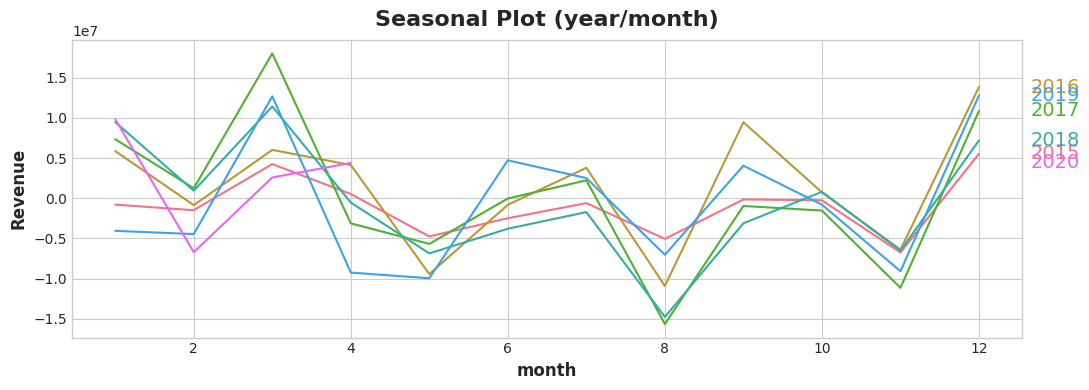

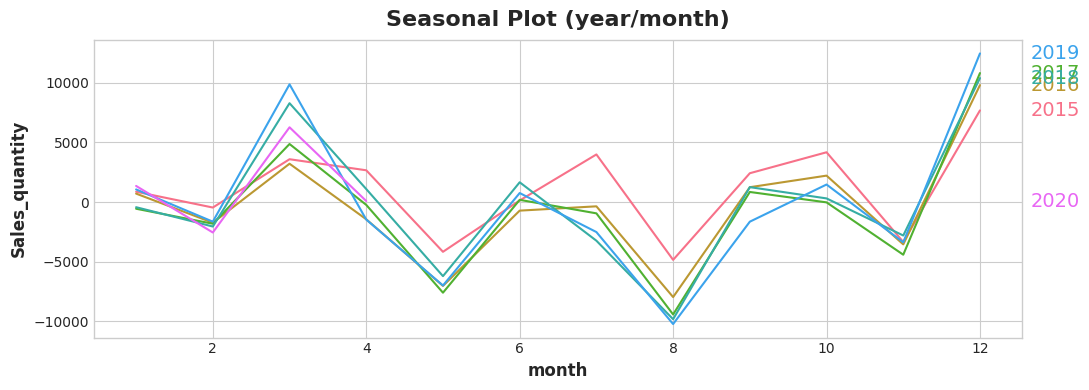

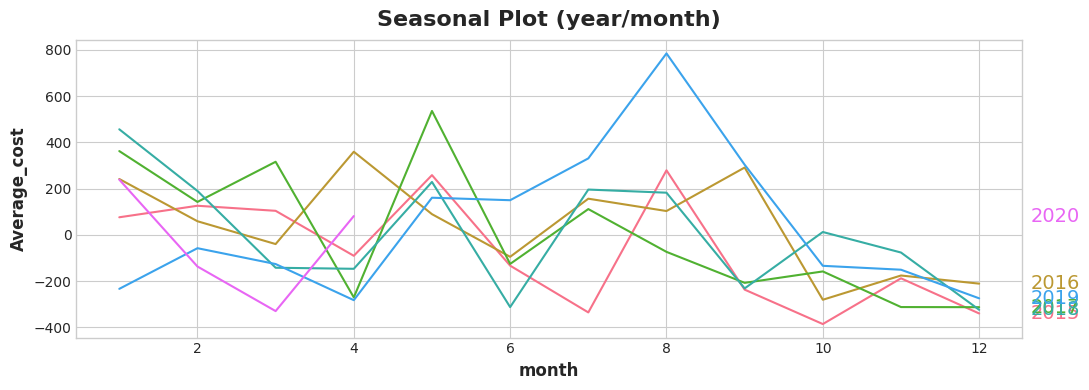

In [10]:
detrended_train = pd.DataFrame()
detrended_train["Revenue"] = revenue_detrended
detrended_train["Sales_quantity"] = sales_quantity_detrended
detrended_train["Average_cost"] = average_cost_detrended
detrended_train["The_average_annual_payroll_of_the_region"] = payroll

X = detrended_train.copy()
X["month"] = X.index.month
X["year"] = X.index.year
seasonal_plot(X, y='Revenue', period='year', freq='month');
seasonal_plot(X, y='Sales_quantity', period='year', freq='month');
seasonal_plot(X, y='Average_cost', period='year', freq='month');

<h4>Seasonality - year/month</h4>

There's visible seasonality in year/month comparasion,especially in **Sales_quantity** and **Revenue**

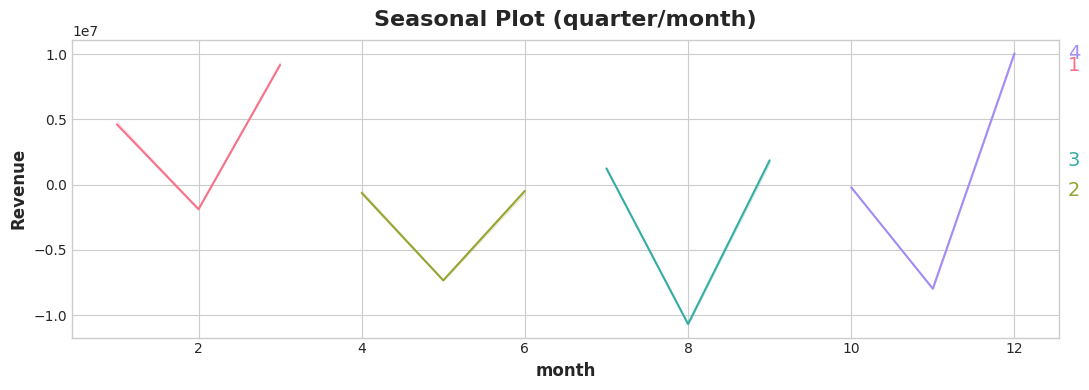

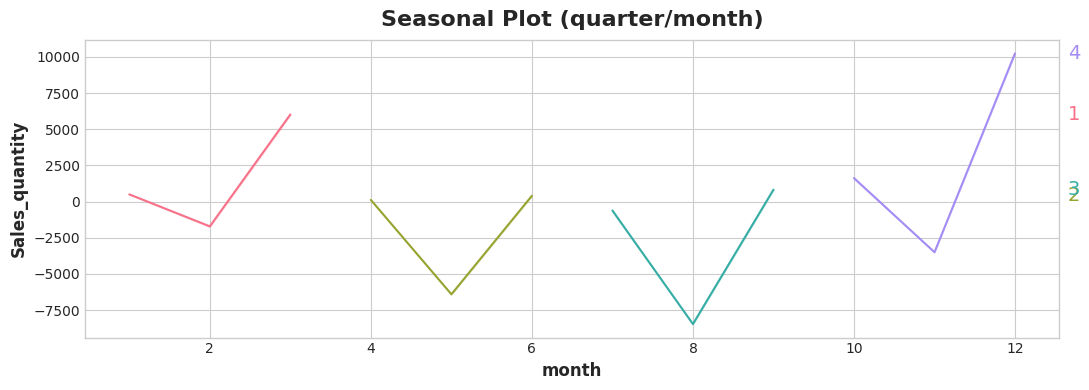

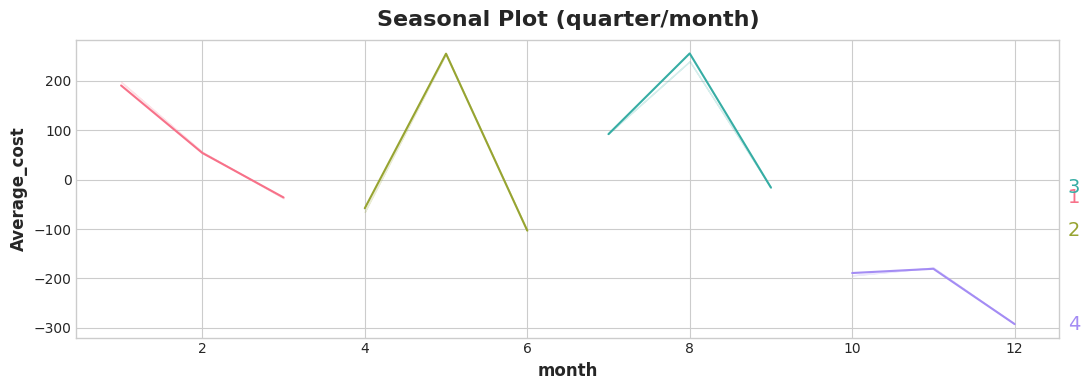

In [11]:
X["quarter"] = X.index.quarter
seasonal_plot(X, y='Revenue', period='quarter', freq='month');
seasonal_plot(X, y='Sales_quantity', period='quarter', freq='month');
seasonal_plot(X, y='Average_cost', period='quarter', freq='month');

<h4>Seasonality - quarter/month</h4>

There's visible seasonality in quarter/month comparasion

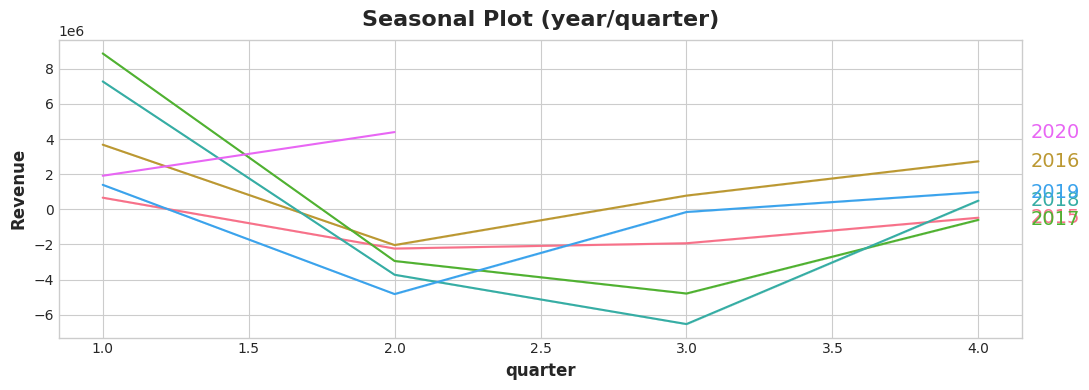

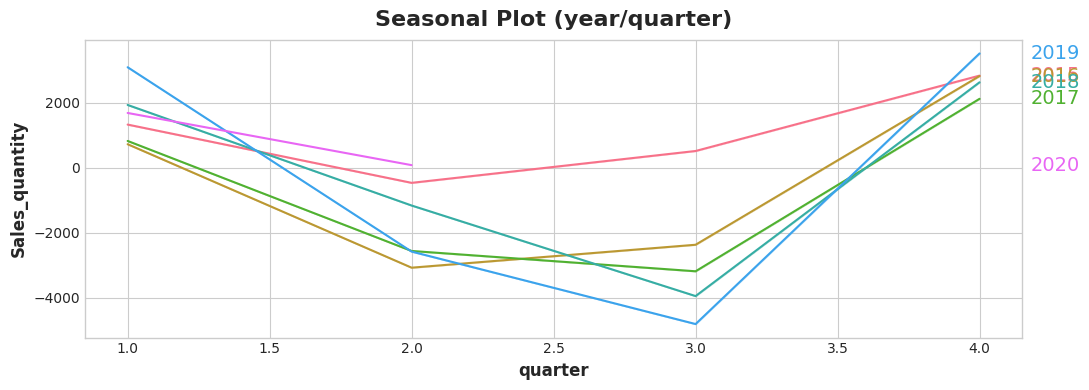

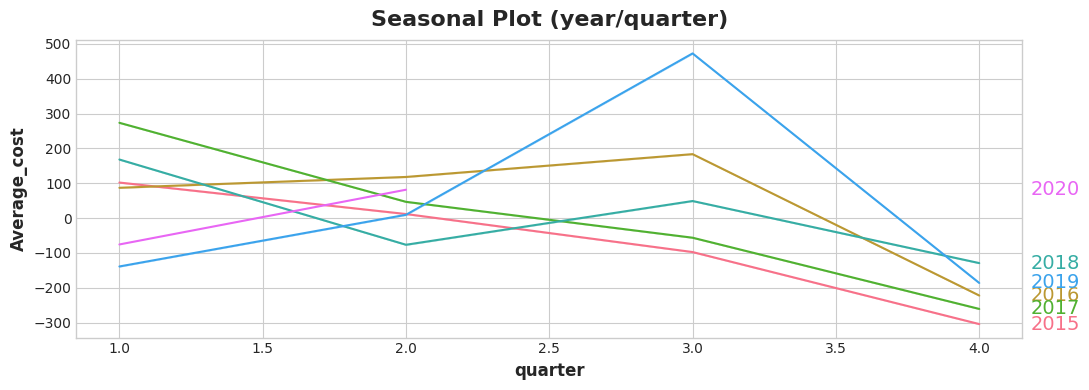

In [12]:
seasonal_plot(X, y='Revenue', period='year', freq='quarter');
seasonal_plot(X, y='Sales_quantity', period='year', freq='quarter');
seasonal_plot(X, y='Average_cost', period='year', freq='quarter');

<h4>Seasonality - year/quarter</h4>

There's visible seasonality in year/quarter comparasion

When all years are overlapped there is **visible pattern**. Anually and quartaly

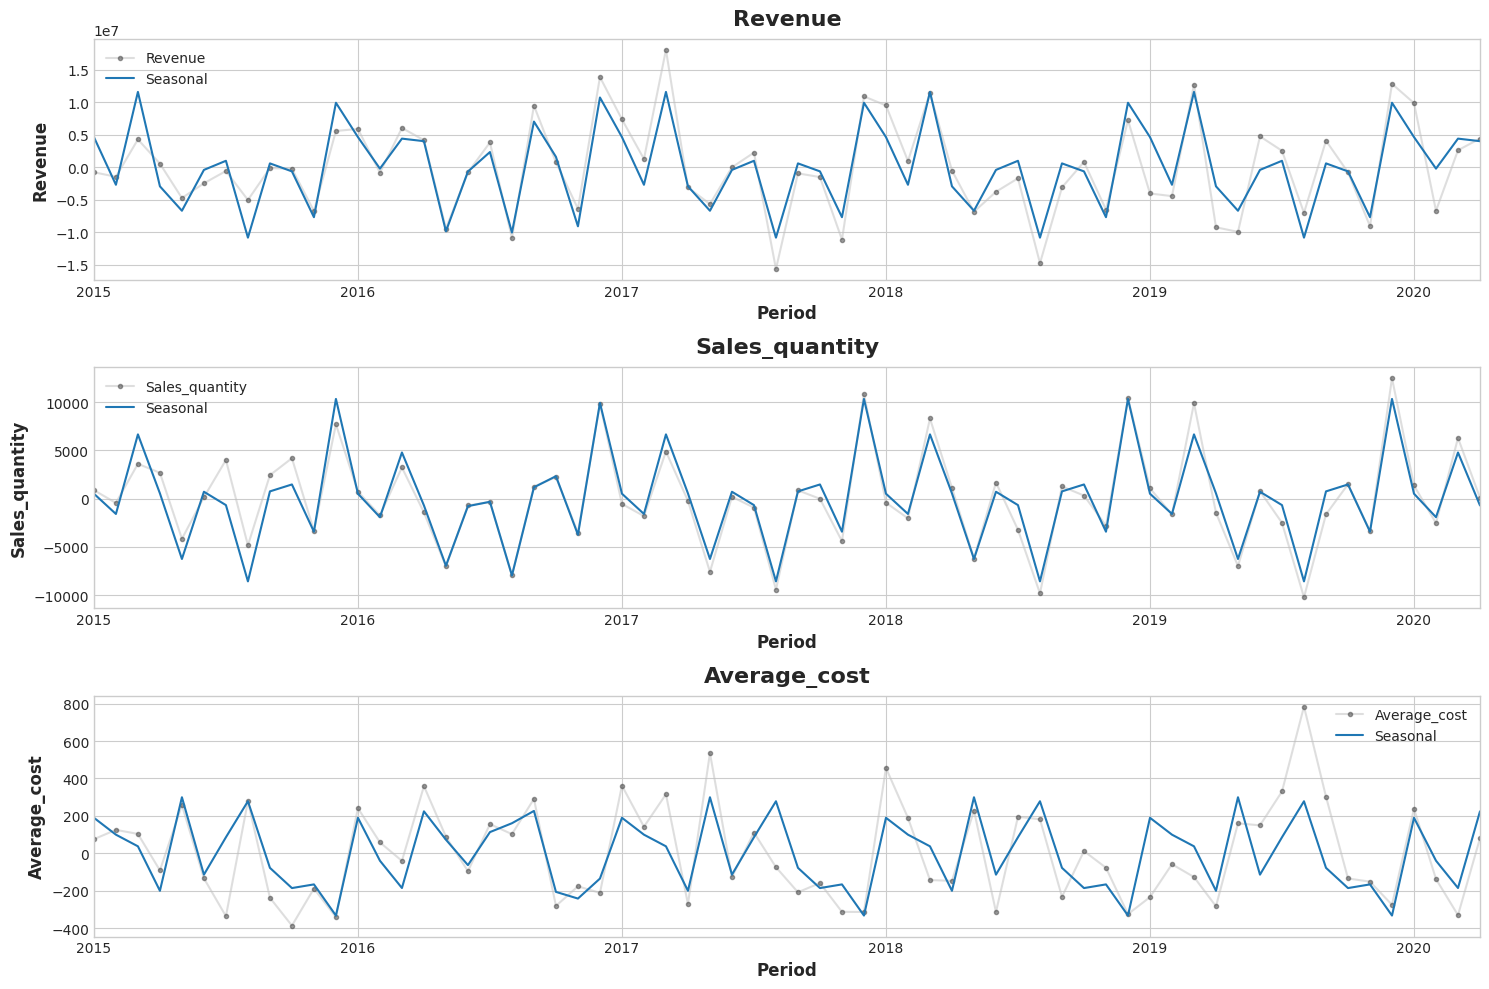

In [13]:
fourier_M = CalendarFourier(freq="M", order=4)
fourier_Y = CalendarFourier(freq="Y", order=4)
dp = DeterministicProcess(
    index=detrended_train.index,
    constant=True,
    order=0,
    seasonal=True,
    additional_terms=[fourier_M, fourier_Y],
    drop=True,
)
X = dp.in_sample()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
axes = axes.flatten()


# There are stored seasons
seasons = []
dps = []

for i, col in enumerate(detrended_train.columns):
    if i == 3:
        break
    # Average_sales
    if i == 2:
        fourier_Y = CalendarFourier(freq="Y", order=4)
        fourier_Q = CalendarFourier(freq="Q", order=4)
        fourier_M = CalendarFourier(freq="M", order=4)
        dp = DeterministicProcess(
            index=detrended_train.index,
            constant=True,
            order=0,
            seasonal=True,
            additional_terms=[fourier_Y, fourier_Q, fourier_M],
            drop=True,
        )
    X = dp.in_sample()
      
    dps.append(dp)  
    y = detrended_train[col].copy()
    model = LinearRegression().fit(X, y)
    y_pred = pd.Series(
        model.predict(X),
        index=X.index,
        name='Fitted',
    )
    seasons.append(model.predict(X))
    ax = axes[i] 
    y.plot(ax=ax, **plot_params, alpha=0.5, title=col, ylabel=col)
    y_pred.plot(ax=ax, label="Seasonal")
    ax.legend()

fig.tight_layout()
plt.show()


<div class="alert alert-block alert-success">  
<strong>Seasonality Plots:</strong> Both Revenue and Sales_quantity fit quite well, Average_cost has slightly bigger error.
</div>


# Post-Processing Analysis

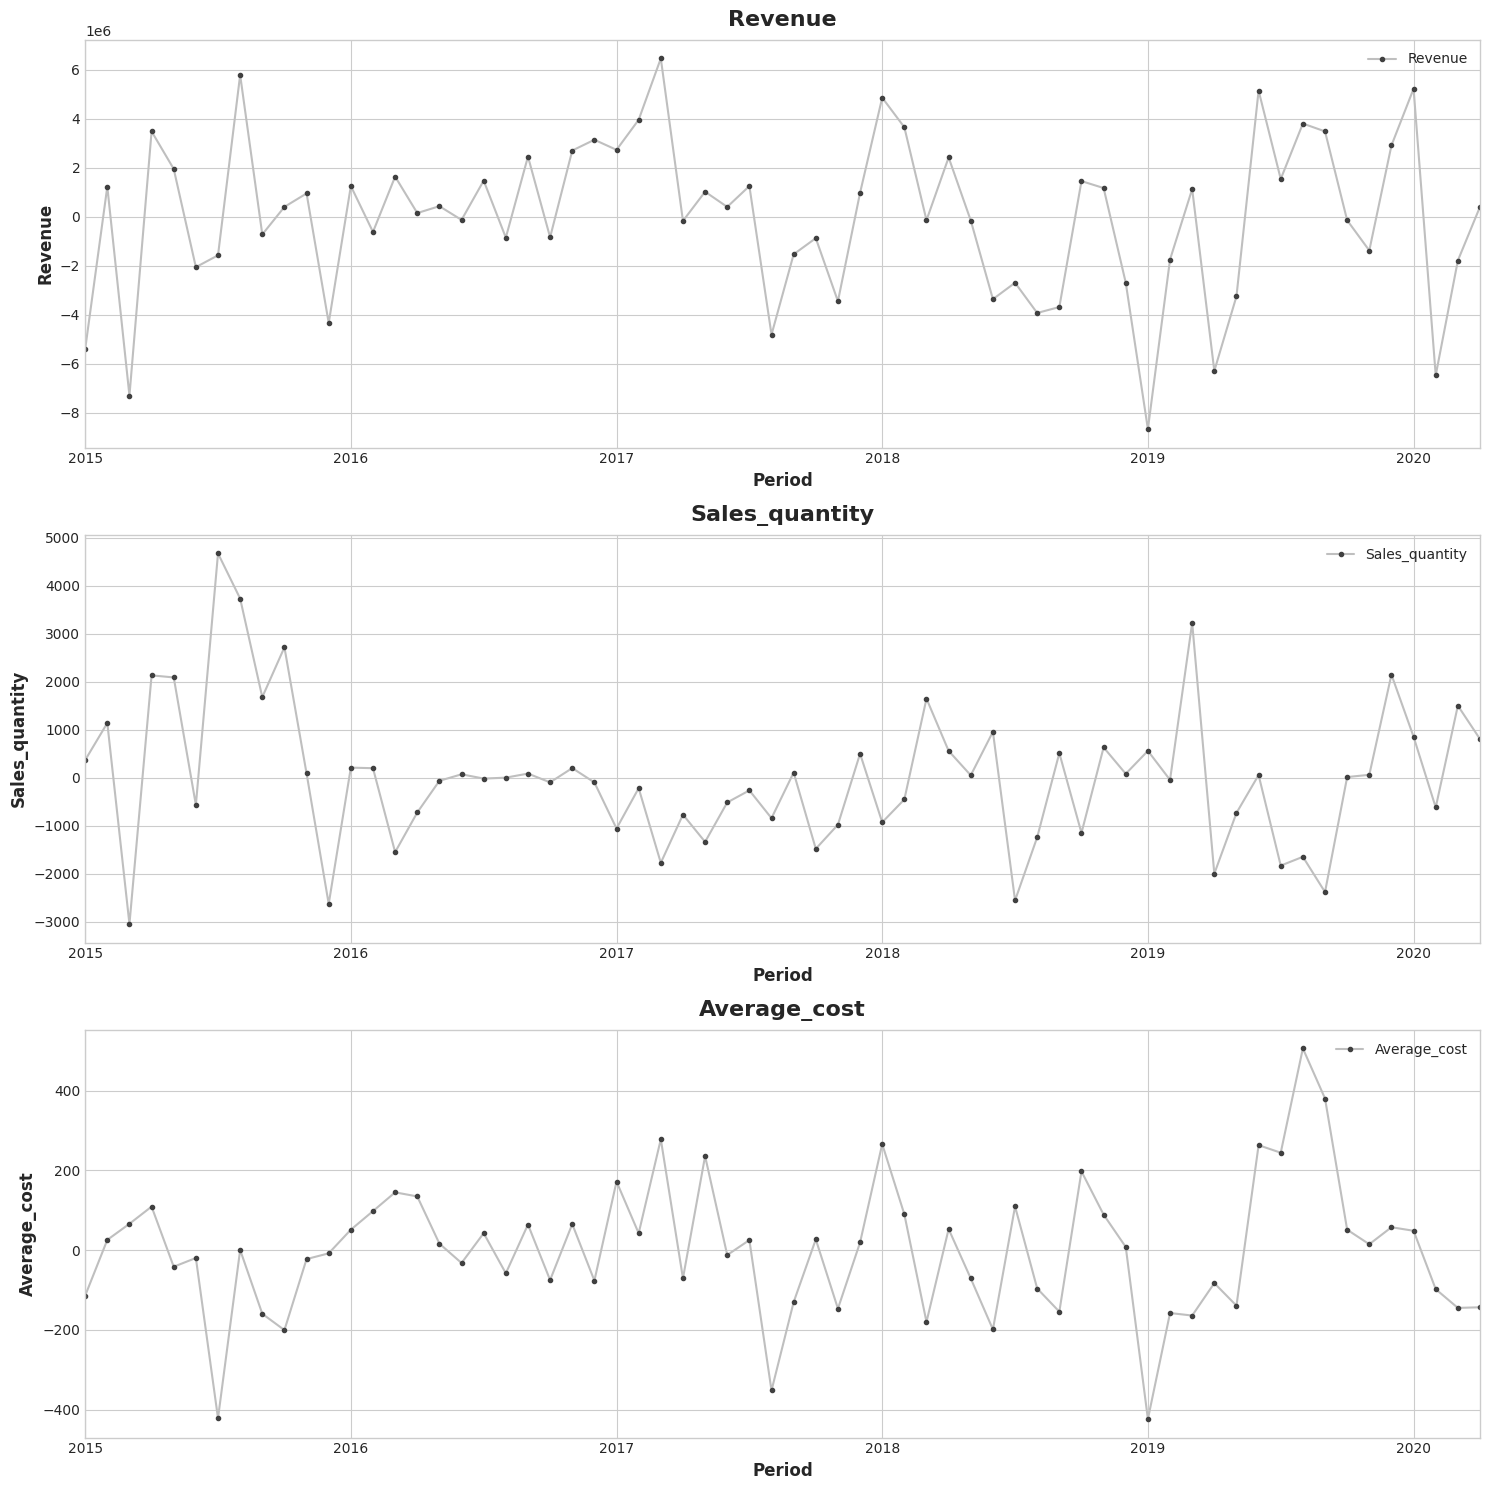

In [14]:
residuals = pd.DataFrame()
residuals["Revenue"] = detrended_train["Revenue"] - seasons[0]
residuals["Sales_quantity"] = detrended_train['Sales_quantity'] - seasons[1]
residuals["Average_cost"] = detrended_train['Average_cost'] - seasons[2]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(residuals.columns):
    ax = axes[i] 
    residuals[col].plot(ax=ax, **plot_params, alpha=1, title=col, ylabel=col)
    ax.legend()

fig.tight_layout()
plt.show()

<h3>Detrended and Deseasoned Data</h3> 

This is what the data looks like after removing trends and seasonality.

It looks like there might still be some hidden pattern, in order to check that, lets examine histplots, to check if the leftover data is pure error or something has been missed.

<Axes: xlabel='Revenue', ylabel='Count'>

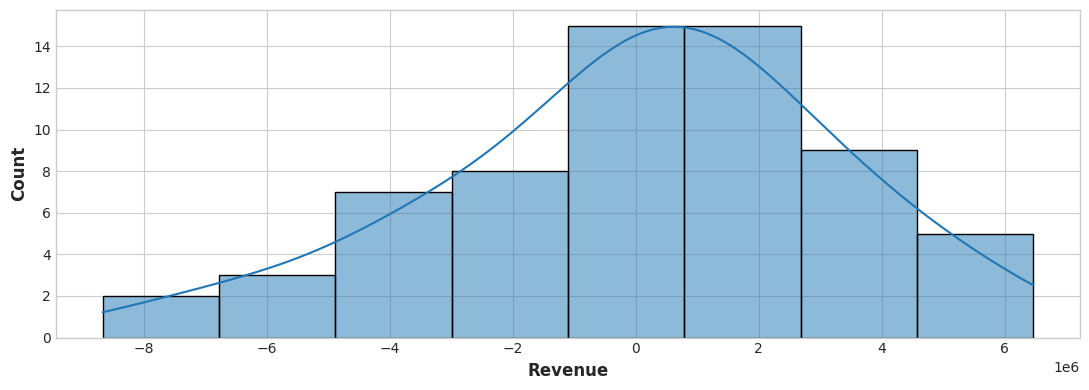

In [15]:
sns.histplot(residuals["Revenue"], kde=True)

<Axes: xlabel='Sales_quantity', ylabel='Count'>

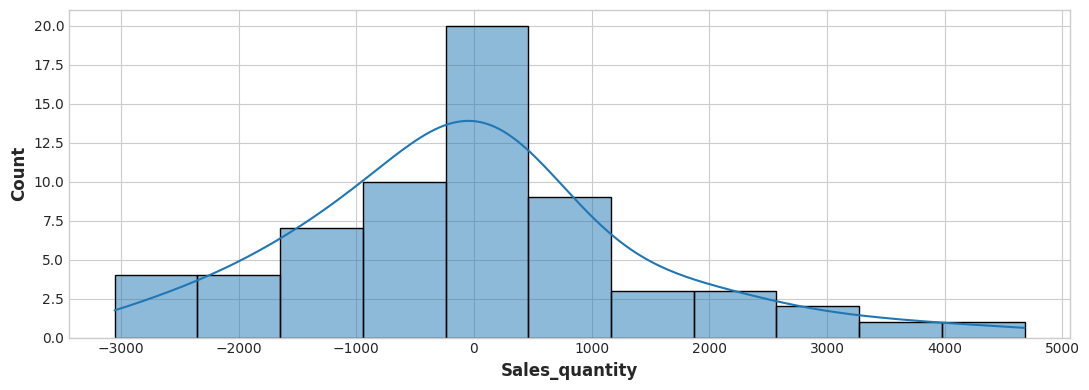

In [16]:
sns.histplot(residuals["Sales_quantity"], kde=True)

<Axes: xlabel='Average_cost', ylabel='Count'>

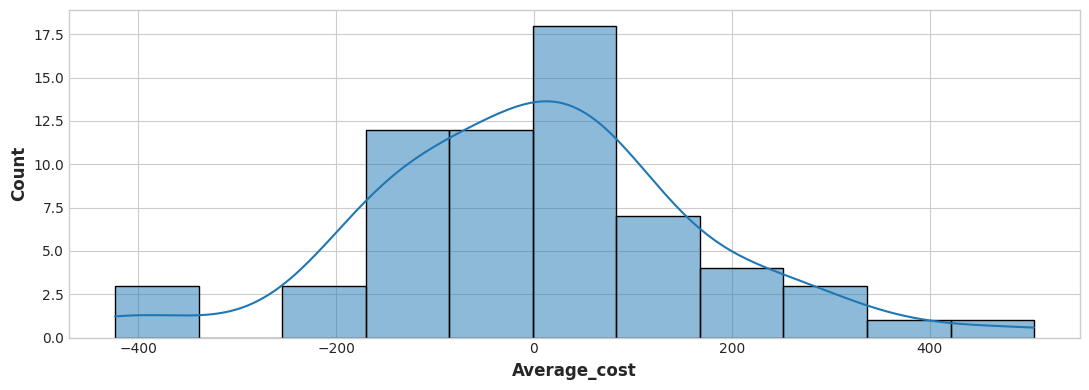

In [17]:
sns.histplot(residuals["Average_cost"], kde=True)

<div class="alert alert-block alert-info">
<strong>Histplots:</strong> Based on these plots, we can assume leftover data comes from normal distribution, this is indicated by the bell-curved shape.
</div>


<h3>ACF and PACF</h3>

ADF Statistic: -7.027641493501455
p-value: 6.303874769236736e-10
ADF Statistic: -3.3235724457437645
p-value: 0.01385710941243007
ADF Statistic: -4.532782694229517
p-value: 0.00017149033489049614


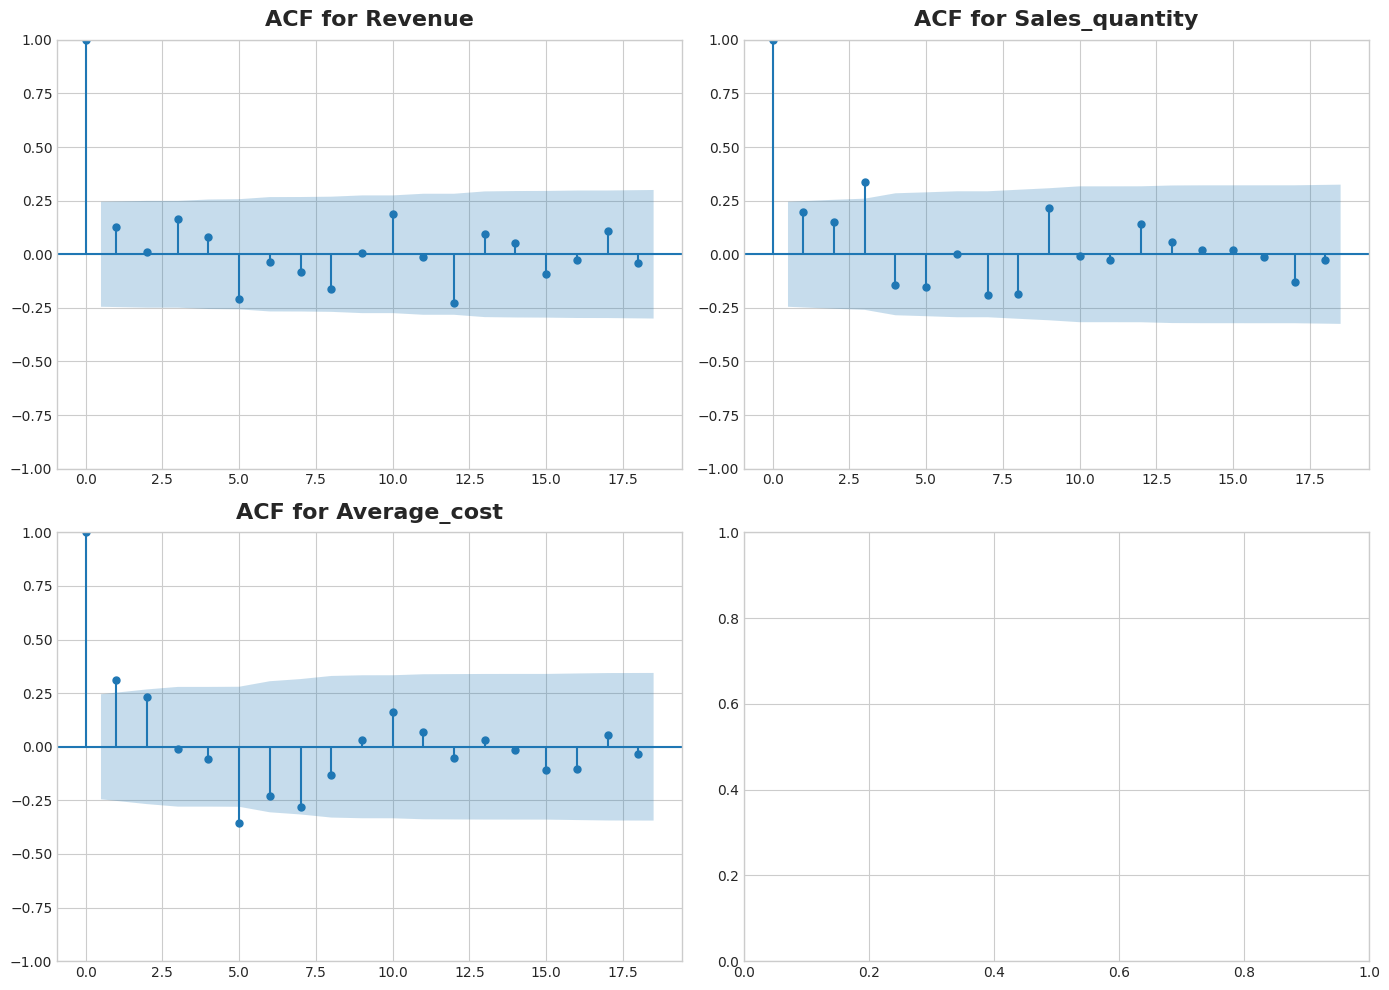

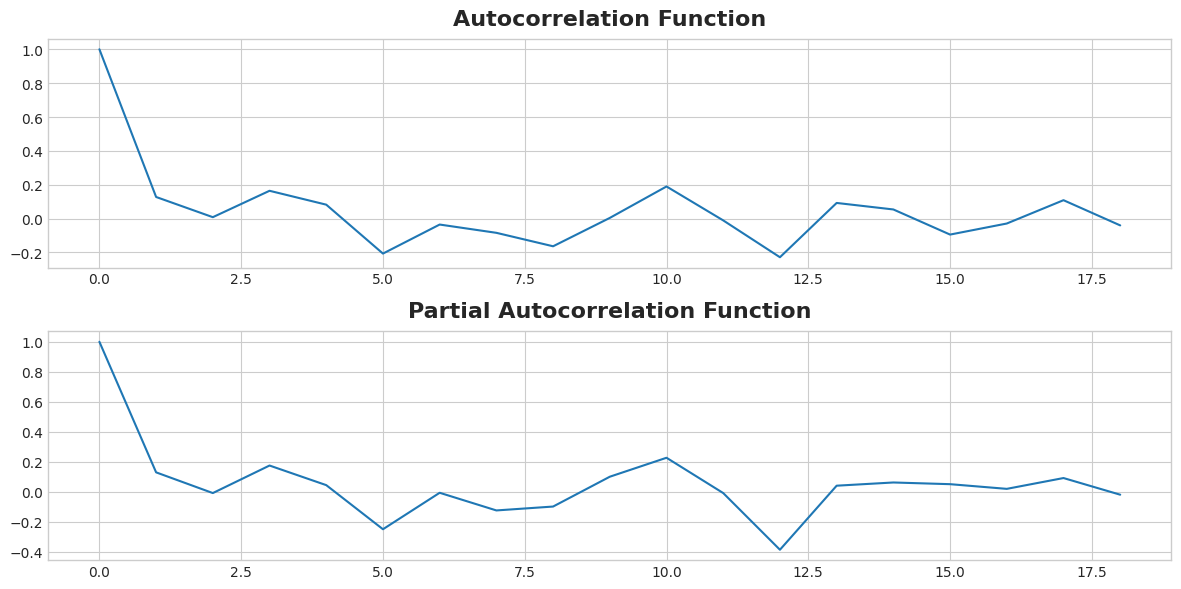

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for col in residuals.columns:
    result = adfuller(residuals[col])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

for i, column in enumerate(residuals.columns):
    plot_acf(residuals[column], lags=18, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'ACF for {column}')

plt.tight_layout()
plt.show()


# ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(acf(residuals['Revenue'], nlags=18))
plt.title('Autocorrelation Function')
plt.subplot(212)
plt.plot(pacf(residuals['Revenue'], nlags=18))
plt.title('Partial Autocorrelation Function')
plt.show()

All three time series "Revenue," "Sales_quantity," and "Average_cost" appear to be stationary, as indicated by the negative ADF statistics and low p-values.

This is although not required by the LSTM model.

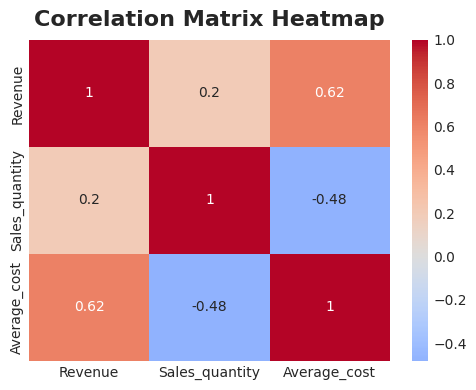

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.195838,0.616481
Sales_quantity,0.195838,1.000000,-0.482058
Average_cost,0.616481,-0.482058,1.000000


In [19]:
correlation_matrix = residuals.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()
correlation_matrix

<div class="alert alert-block alert-success">  
<strong>Correlation Matrix:</strong> Despite removing trends and seasonality, leftover data remains <strong>correlated</strong>.  
</div>

# Model Training and Evaluation

The model used in this problem will be Long Short-Term Memory (LSTM) network, a type of Recurrent Neural Network (RNN) that is particularly well-suited for handling sequential data and capturing long-term dependencies. In order to perform training effectively, data must be scaled to ensure optimal performance of the LSTM model.

Data scaling is a crucial preprocessing step. It involves normalizing or standardizing the input data to bring it within a specific range or distribution. This process helps to stabilize and accelerate the training process by mitigating issues related to differing magnitudes of feature values.

In this particular example StandardScaler will be applied.

In order not to lose so much data, sequence_lenght is set to 4.

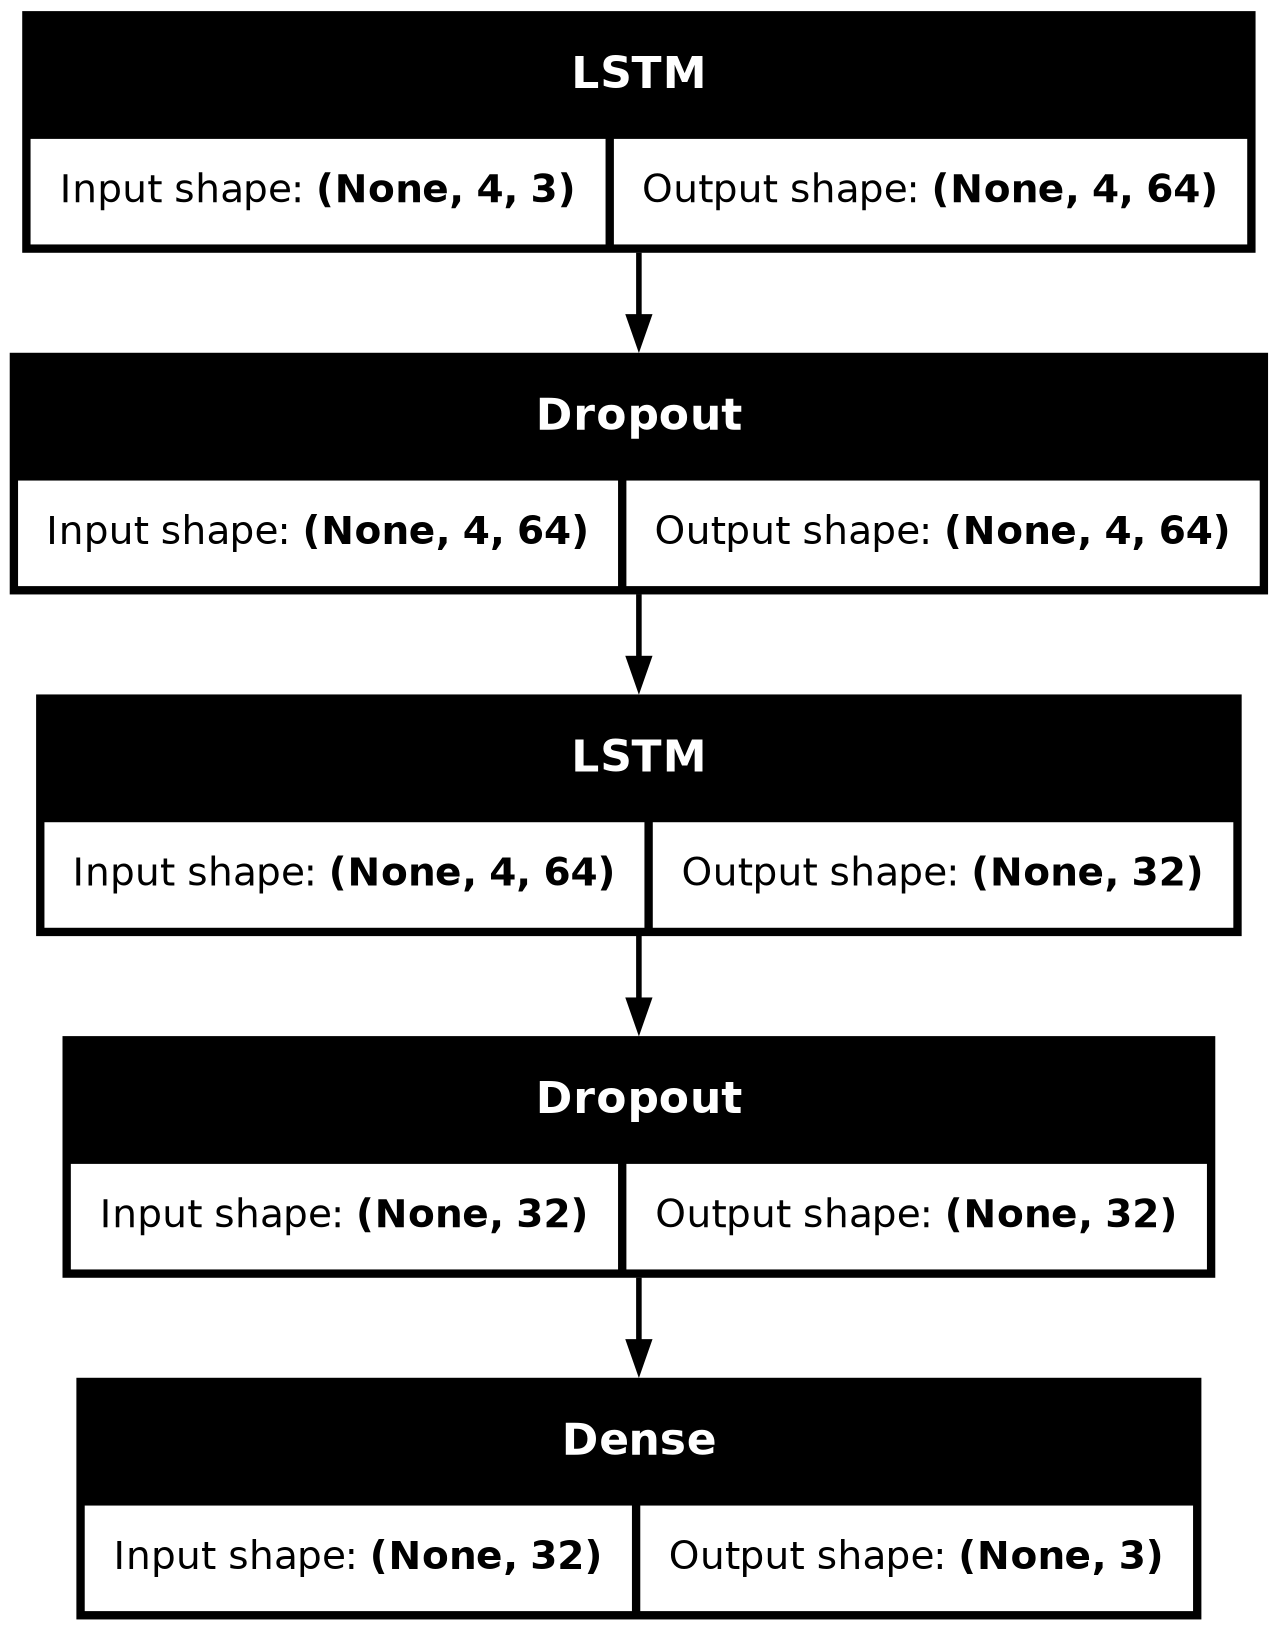

In [20]:
res_revenue = residuals
scaler = StandardScaler()
scaled_residuals = scaler.fit_transform(res_revenue)

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 4
X, y = create_sequences(scaled_residuals, sequence_length)
train_size = int(len(X) * 0.8)
val_size = int(train_size * 0.2)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(units=32),
    Dropout(0.1),
    Dense(X_train.shape[2])
])

model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

<div class="alert alert-block alert-info">
<b>Model:</b> This model might not be fully appropriate and tuned, but once again this is my first time working with timeseries, if you have any suggestions please comment.
</div>




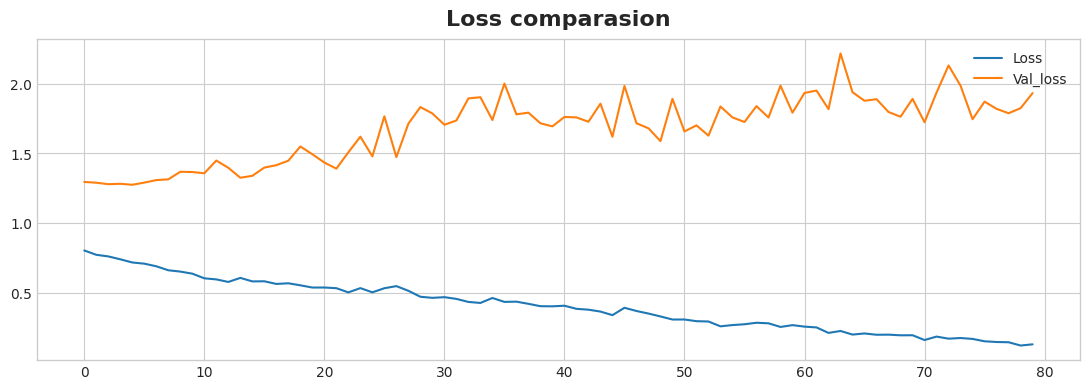

In [21]:
history = model.fit(X_train, y_train, epochs=80, batch_size=1, validation_data=(X_val, y_val), verbose=0)
plt.plot(history.history["loss"], label='Loss')
plt.plot(history.history["val_loss"], label='Val_loss')
plt.title("Loss comparasion")
plt.legend()
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
<strong>Overfitting:</strong> Model might be overfitting. (I'm almost sure it is)
</div>


The validation loss is increasing, which is a part of the learning process (because predicted values are not linear x=0). However, this doesn't mean the model is performing optimally; we should aim to decrease the validation loss.

# Predicting on Test Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean squared error: 1.6717623820662133
Mean absolute error: 1.1080786801329425


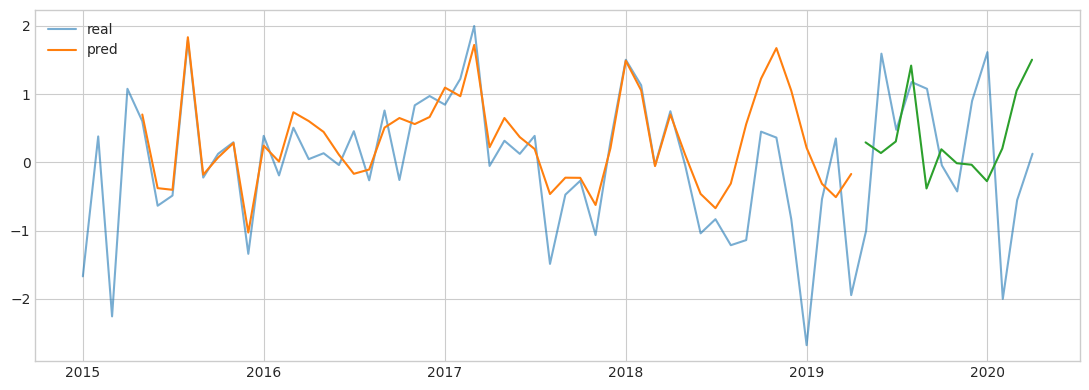

In [22]:
predicted_revenue = model.predict(X_train)
predicted_val = model.predict(X_val)
predicted_test = model.predict(X_test)[:, 0]

predicted_revenue = np.concatenate((predicted_revenue, predicted_val))
plt.plot(res_revenue.index.to_timestamp(), scaled_residuals[:, 0], label="real", alpha=0.6)
plt.plot(res_revenue.index[sequence_length:len(predicted_revenue)+sequence_length].to_timestamp(), predicted_revenue[:, 0], label="pred")
plt.plot(res_revenue.index[len(predicted_revenue)+sequence_length-1:-1], predicted_test)

mse_test = mean_squared_error(predicted_test, y_test[:, 0])
mae_test = mean_absolute_error(predicted_test, y_test[:, 0])
print(f"Mean squared error: {mse_test}\nMean absolute error: {mae_test}")
plt.legend()
plt.tight_layout()

These predictions are far from right, nevertheless, they can be used for forecasting. 
Lets combine them with removed **trends** and **seasonality** and see what we get.

In [23]:
res_revenue_full = pd.concat([residuals, test])

scaler = StandardScaler()
scaled_residuals_full = scaler.fit_transform(res_revenue_full)

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 4
X_full, y_full = create_sequences(scaled_residuals_full, sequence_length)
#predict_full = model.predict(X_full)
#plt.plot(res_revenue_full.index[4:len(res_revenue_full)].to_timestamp(), predict_full)

def predict_future(model, data, steps, sequence_length):
    predictions = []
    current_sequence = data[-sequence_length:]

    for _ in range(steps):
        next_value = model.predict(current_sequence.reshape(1, sequence_length, -1), verbose=0)
        predictions.append(next_value[0])
        current_sequence = np.append(current_sequence[1:], next_value, axis=0)
    
    return np.array(predictions)

future_steps = 32

future_predictions = predict_future(model, scaled_residuals, future_steps, sequence_length)


There are 32 steps (monthly periods) in test data, now model is used to predict them step by step.

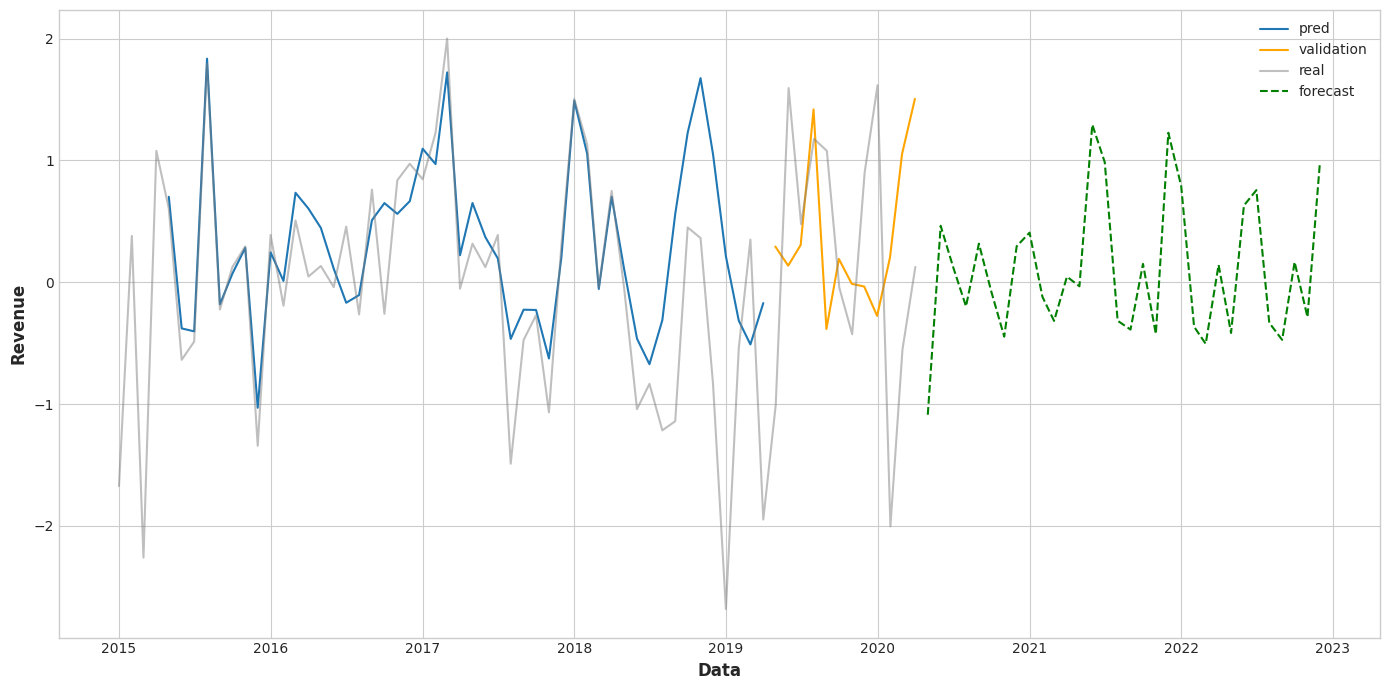

In [24]:
future_df = pd.DataFrame(future_predictions, index=test.index.to_timestamp(), columns=residuals.columns)
plt.figure(figsize=(14, 7))
plt.plot(res_revenue.index[sequence_length:len(predicted_revenue)+sequence_length].to_timestamp(), predicted_revenue[:, 0], label="pred")
plt.plot(res_revenue.index[len(predicted_revenue)+sequence_length-1:-1], predicted_test, color="orange", label="validation")

plt.plot(res_revenue.index.to_timestamp(), scaled_residuals[:,0], label="real",  color="gray", alpha=0.5)

plt.plot(future_df.index, future_predictions[:, 0], label='forecast', linestyle='dashed', color="green")
plt.xlabel('Data')
plt.ylabel('Revenue')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">  
<Strong>Forecast:</Strong> This is what the forecast looks like. It's clear that it needs to be tuned and fixed.  
</div>



# Model Training on Full Data
Now let's train model once again but on full available data (validation set still will be used).

In [25]:
res_revenue = residuals
scaler = StandardScaler()
scaled_residuals = scaler.fit_transform(res_revenue)

sequence_length = 4
X, y = create_sequences(scaled_residuals, sequence_length)
val_size = int(len(X) * 0.2)

X_train, X_val = X[:-val_size], X[-val_size:]
y_train, y_val = y[:-val_size], y[-val_size:]

full_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(units=32),
    Dropout(0.1),
    Dense(X_train.shape[2])
])

full_model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()

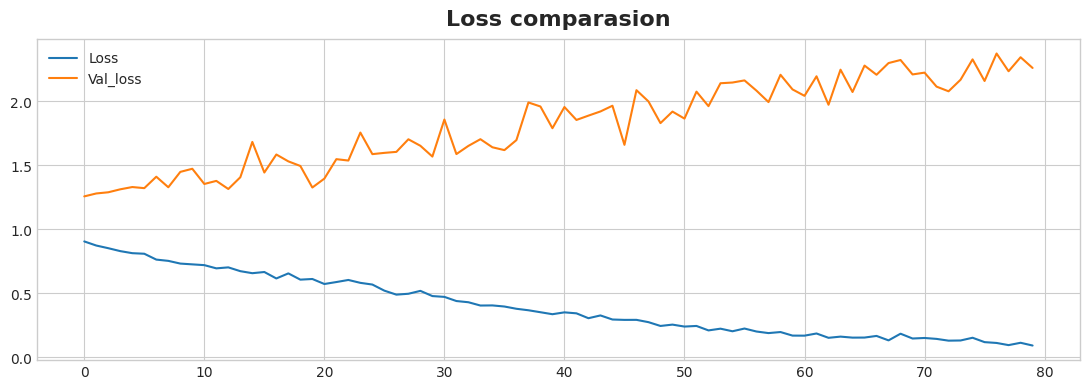

In [26]:
history = full_model.fit(X_train, y_train, epochs=80, batch_size=1, validation_data=(X_val, y_val), verbose=0)
plt.plot(history.history["loss"], label='Loss')
plt.plot(history.history["val_loss"], label='Val_loss')
plt.title("Loss comparasion")
plt.legend()
fig.tight_layout()
plt.show()

# Final Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


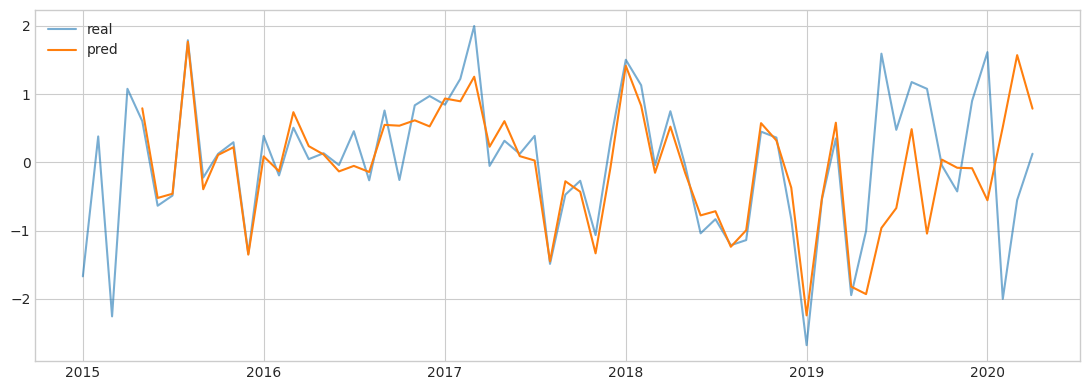

In [27]:
predicted_revenue = full_model.predict(X_train)
predicted_val = full_model.predict(X_val)

predicted_revenue = np.concatenate((predicted_revenue, predicted_val))
plt.plot(res_revenue.index.to_timestamp(), scaled_residuals[:, 0], label="real", alpha=0.6)
plt.plot(res_revenue.index[sequence_length:len(predicted_revenue)+sequence_length].to_timestamp(), predicted_revenue[:, 0], label="pred")

plt.legend()
plt.tight_layout()

This is how model trained on 48 training periods (and 12 validation) performs.

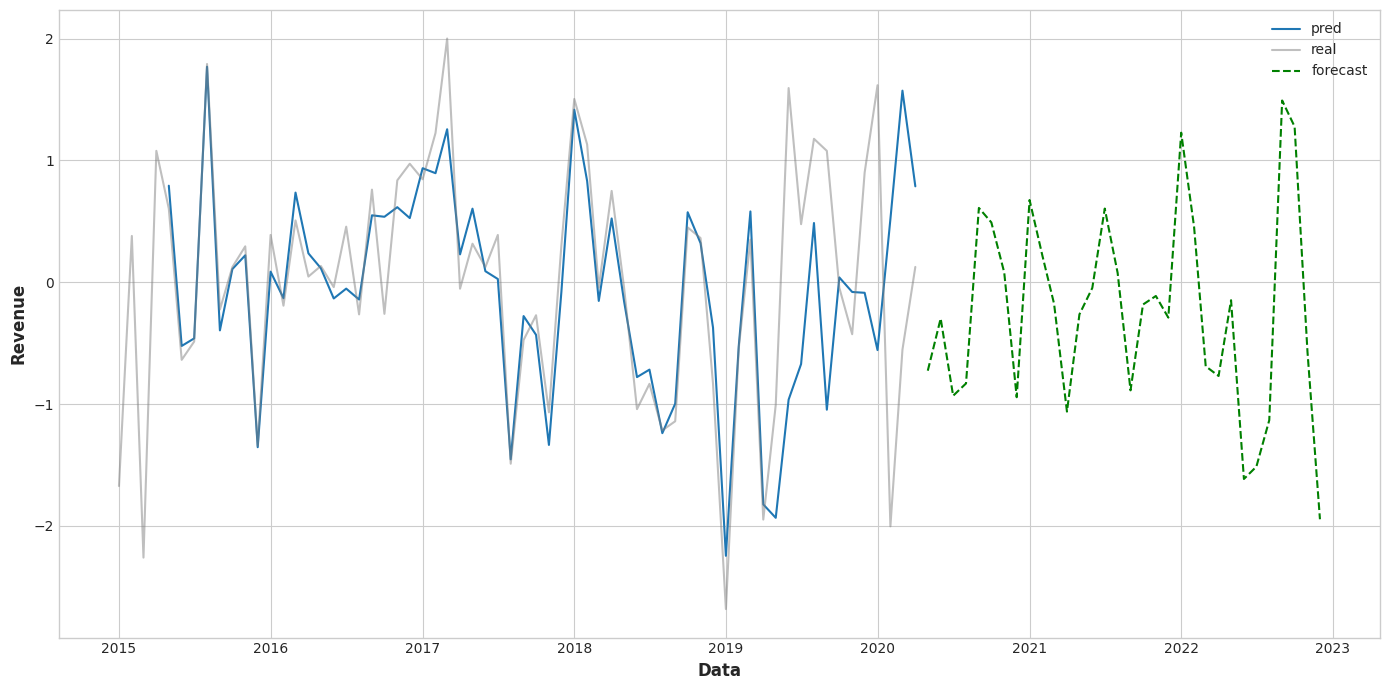

In [28]:
future_predictions_full = predict_future(full_model, scaled_residuals, future_steps, sequence_length)

future_df = pd.DataFrame(future_predictions_full, index=test.index.to_timestamp(), columns=residuals.columns)
plt.figure(figsize=(14, 7))
plt.plot(res_revenue.index[sequence_length:len(predicted_revenue)+sequence_length].to_timestamp(), predicted_revenue[:, 0], label="pred")

plt.plot(res_revenue.index.to_timestamp(), scaled_residuals[:,0], label="real",  color="gray", alpha=0.5)

plt.plot(future_df.index, future_predictions_full[:, 0], label='forecast', linestyle='dashed', color="green")
plt.xlabel('Data')
plt.ylabel('Revenue')
plt.legend()
plt.show()

# Completing Components For Forecasting
Before combining all compontents:
* Trends
* Seasonality
* LSTM

Data has to be unscaled first

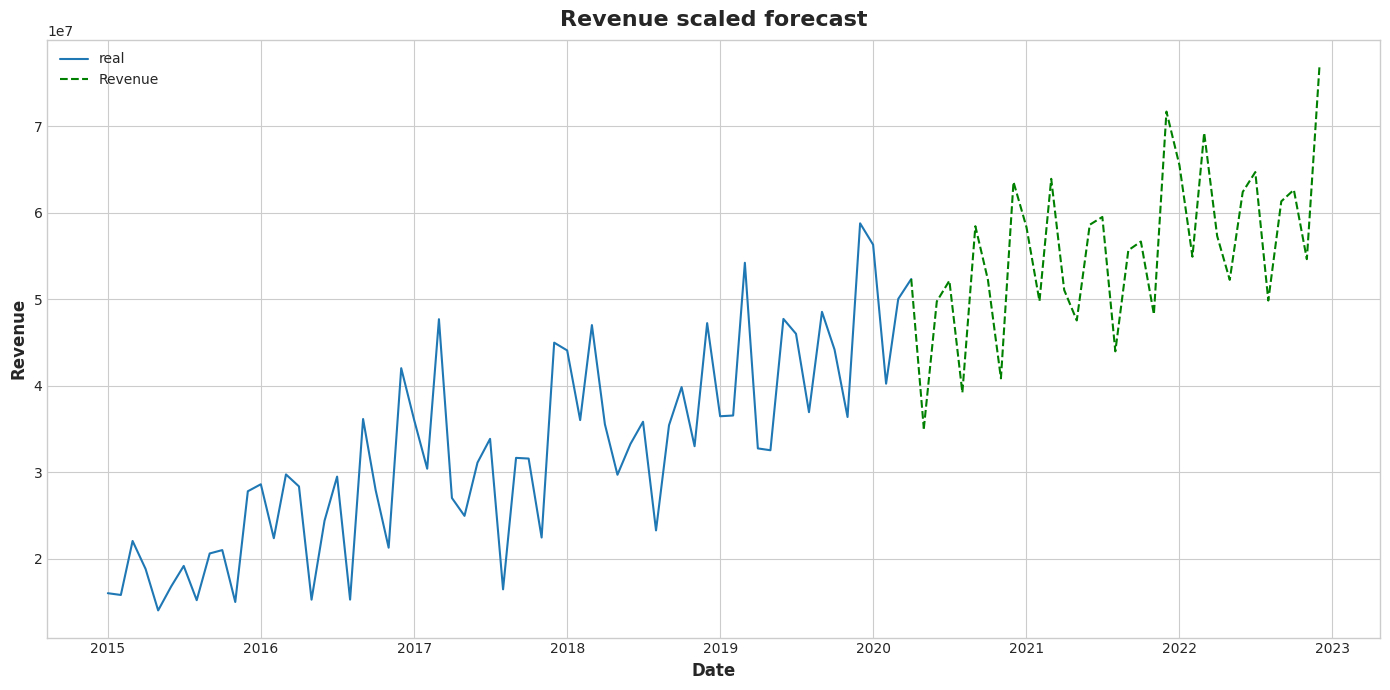

In [29]:
scaler = StandardScaler()
scaled_residuals = scaler.fit_transform(res_revenue)

plt.figure(figsize=(14, 7))
future_unscaled = scaler.inverse_transform(future_predictions)

future_df_unscaled = pd.DataFrame(future_unscaled, index=test.index.to_timestamp(), columns=residuals.columns)

trend_revenue = res_revenue["Revenue"] + trends[0]
full_revenue = trend_revenue + seasons[0]

future_unscaled_with_trend = future_unscaled.copy()
for i in range(len(future_df_unscaled.index)):
    future_unscaled_with_trend[i, 0] = (eval(equations["Revenue"].replace("t", str(len(train)+i+1)))) + future_unscaled[i, 0]
    
full_future = future_unscaled_with_trend[:, 0] + seasons[0][16:32+16]

plt.plot(res_revenue.index.to_timestamp(), full_revenue, label="real")
plt.plot(future_df_unscaled.index, full_future, label='Revenue', linestyle='dashed', color="green")

# connector plot
data = {
    'Date': [res_revenue.index[-1].to_timestamp(),future_df_unscaled.index[0]],
    'Values': [full_revenue[-1], full_future[0]]
}

connector = pd.DataFrame(data)
connector['Date'] = pd.to_datetime(connector['Date'])
connector.set_index('Date', inplace=True)
plt.plot(connector, linestyle='dashed', color="green")

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title("Revenue scaled forecast")
plt.legend()
plt.show()

<div style="white-space: pre; font-family: monospace; background-color: green; color: white; padding: 10px;">^
|
|  Final forecast for Revenue
|
</div>


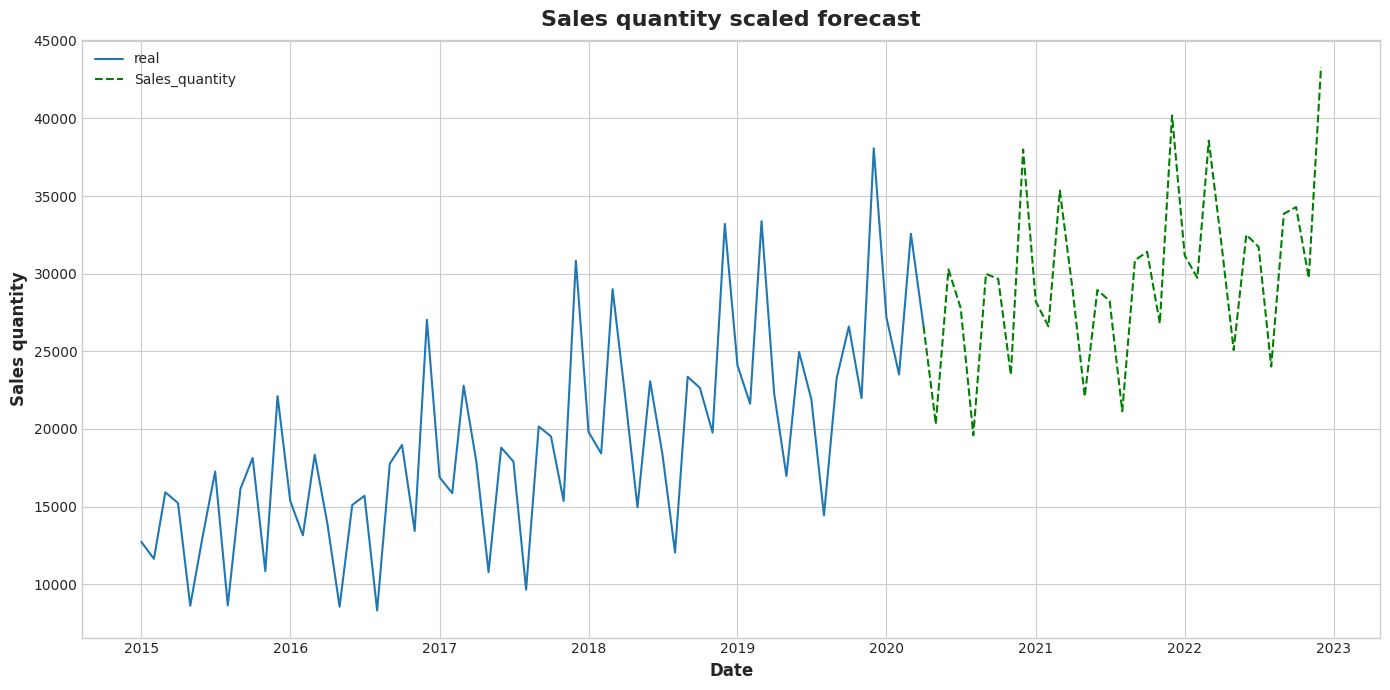

In [30]:
trend_sales = residuals["Sales_quantity"] + trends[1]
full_sales = trend_sales + seasons[1]

plt.figure(figsize=(14, 7))
plt.plot(residuals.index.to_timestamp(), full_sales, label="real")

future_unscaled_with_trend = future_unscaled.copy()
for i in range(len(future_df_unscaled.index)):
    future_unscaled_with_trend[i, 1] = (eval(equations["Sales_quantity"].replace("t", str(len(train)+i+1)))) + future_unscaled[i, 1]
full_future = future_unscaled_with_trend[:, 1] + seasons[1][16:32+16]

plt.plot(future_df_unscaled.index, full_future, label='Sales_quantity', linestyle='dashed', color="green")

# connector plot
data = {
    'Date': [res_revenue.index[-1].to_timestamp(),future_df_unscaled.index[0]],
    'Values': [full_sales[-1], full_future[0]]
}

connector = pd.DataFrame(data)
connector['Date'] = pd.to_datetime(connector['Date'])
connector.set_index('Date', inplace=True)
plt.plot(connector, linestyle='dashed', color="green")

plt.xlabel('Date')
plt.ylabel('Sales quantity')
plt.title("Sales quantity scaled forecast")
plt.legend()
plt.show()

<div style="white-space: pre; font-family: monospace; background-color: blue; color: white; padding: 10px;">^
|
|  Final forecast for Sales_quantity
|
</div>


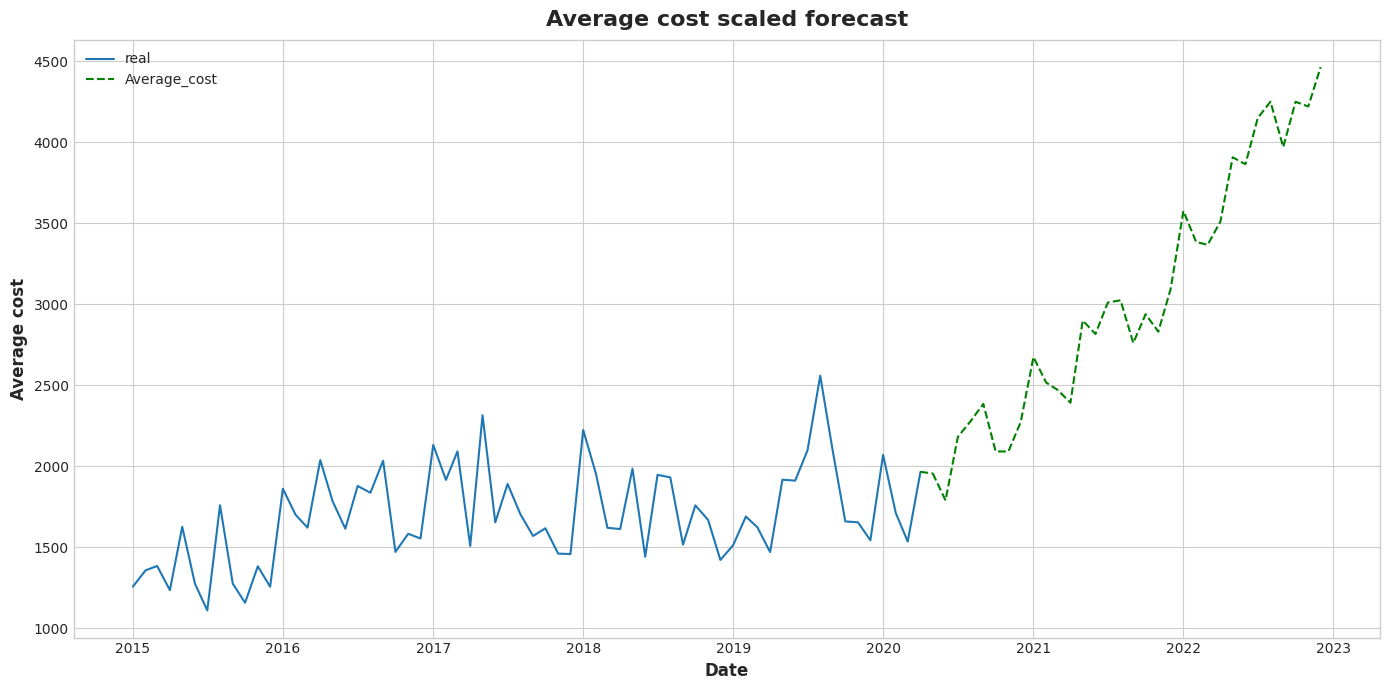

In [31]:
trend_cost = residuals["Average_cost"] + trends[2]
full_cost= trend_cost + seasons[2]
plt.figure(figsize=(14, 7))
plt.plot(residuals.index.to_timestamp(), full_cost, label="real")

future_unscaled_with_trend = future_unscaled.copy()
for i in range(len(future_df_unscaled.index)):
    future_unscaled_with_trend[i, 2] = (eval(equations["Average_cost"].replace("t", str(len(train)+i+1)).replace("^", "**"))) + future_unscaled[i, 2]
full_future = future_unscaled_with_trend[:, 2] + seasons[2][16:32+16]

plt.plot(future_df_unscaled.index, full_future, label='Average_cost', linestyle='dashed', color="green")

# connector plot
data = {
    'Date': [res_revenue.index[-1].to_timestamp(),future_df_unscaled.index[0]],
    'Values': [full_cost[-1], full_future[0]]
}

connector = pd.DataFrame(data)
connector['Date'] = pd.to_datetime(connector['Date'])
connector.set_index('Date', inplace=True)
plt.plot(connector, linestyle='dashed', color="green")

plt.xlabel('Date')
plt.ylabel('Average cost')
plt.title("Average cost scaled forecast")
plt.legend()
plt.show()

<div style="white-space: pre; font-family: monospace; background-color: orange; color: white; padding: 10px;">^
|
|  Final forecast for Average_cost
|
</div>


<div class="alert alert-block alert-warning">  
<Strong>Forecast:</Strong> The current forecast shows a strong upward trend, which might not be the most accurate prediction. To improve trend predictions, it may be beneficial to apply different orders of the DeterministicProcess or, even better, to examine trend correlations. This approach could lead to a more realistic projection of the Average_cost trend. On the other hand, this data might indeed be accurate. To verify this, other factors, such as the inflation rate, should be considered.
</div>



# Conclusion

<h2> LSTM MODEL HAS TO BE TUNED / FIXED / CHANGED</h2>

In [32]:
# How much residuals (LSTM model based predictons) impacts final forecast?

print("Absolute impact relative to values")
res_mean = (abs(residuals["Revenue"]) / train["Revenue"] * 100).mean()
res_mean += (abs(residuals["Sales_quantity"]) / train["Sales_quantity"] * 100).mean()
res_mean += (abs(residuals["Average_cost"]) / train["Average_cost"] * 100).mean()
res_mean = res_mean / 3
print(f"Residuals - (LSTM model based predictons) impacts final forecast on average by {res_mean.round(2)} %")

trend_mean = (abs(trends[0]) / train["Revenue"] * 100).mean()
trend_mean += (abs(trends[1]) / train["Sales_quantity"] * 100).mean()
trend_mean += (abs(trends[2]) / train["Average_cost"] * 100).mean()
trend_mean = trend_mean / 3
print(f"Trends - impacts final forecast on average by {trend_mean.round(2)} %")

season_mean = (abs(seasons[0]) / train["Revenue"] * 100).mean()
season_mean = (abs(seasons[1]) / train["Sales_quantity"] * 100).mean()
season_mean = (abs(seasons[2]) / train["Average_cost"] * 100).mean()
season_mean = season_mean / 3
print(f"Seasons - impacts final forecast on average by {season_mean.round(2)} %")

Absolute impact relative to values
Residuals - (LSTM model based predictons) impacts final forecast on average by 7.47 %
Trends - impacts final forecast on average by 104.99 %
Seasons - impacts final forecast on average by 3.39 %
